In [1]:
import os  # type: ignore
import sys  # type: ignore
import pandas as pd # type: ignore
import numpy as np  # type: ignore  # noqa: F401
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder # type: ignore  # noqa: F401
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from typing import Tuple, Union, List, Dict, Any  # noqa: F401

# ============================================================
# ✅ Add the project root to sys.path (not /core)
# ============================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/claudiatagbo/Masterschool/traveltide


In [2]:
# Verify that core is importable
try:
    import core
    print(":weißes_häkchen: core module found at:", core.__file__)
except ModuleNotFoundError:
    print(":x: core module not found. Check your sys.path!")

:weißes_häkchen: core module found at: None


In [3]:
# Pfad für Feature-Metriken
pca_data_path = os.path.join(project_root, 'data', 'processed', 'pca')
pca_fig_path = os.path.join(project_root, 'reports', 'viz', 'pca')
#eda_data_path = os.path.join(project_root, 'reports', 'eda', 'results')
os.makedirs(pca_data_path, exist_ok=True)
os.makedirs(pca_fig_path, exist_ok=True)
#os.makedirs(eda_data_path, exist_ok=True)

In [4]:
from core.load_data import load_table

:weißes_häkchen: Connected to PostgreSQL database.


In [5]:
df_users = load_table(data_type='feature', table_name='user_base')

 Lade Tabelle 'user_base' aus CSV: /Users/claudiatagbo/Masterschool/traveltide/core/../data/processed/feature_metrics/user_base.csv
 CSV geladen. Zeilen: 5998


In [6]:
df_users.columns

Index(['user_id', 'num_clicks', 'avg_session_clicks', 'num_empty_sessions',
       'num_canceled_trips', 'num_sessions', 'avg_session_duration',
       'num_trips', 'num_destinations', 'num_flights', 'num_hotels',
       'avg_money_spent_flight', 'avg_time_after_booking',
       'avg_money_spent_per_seat', 'avg_money_spent_hotel', 'avg_km_flown',
       'avg_bags', 'gender', 'married', 'has_children', 'home_country',
       'home_city', 'age'],
      dtype='object')

In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   5998 non-null   int64  
 1   num_clicks                5998 non-null   int64  
 2   avg_session_clicks        5998 non-null   float64
 3   num_empty_sessions        5998 non-null   int64  
 4   num_canceled_trips        5998 non-null   int64  
 5   num_sessions              5998 non-null   int64  
 6   avg_session_duration      5998 non-null   float64
 7   num_trips                 5542 non-null   float64
 8   num_destinations          5542 non-null   float64
 9   num_flights               5542 non-null   float64
 10  num_hotels                5542 non-null   float64
 11  avg_money_spent_flight    5173 non-null   float64
 12  avg_time_after_booking    5180 non-null   float64
 13  avg_money_spent_per_seat  5173 non-null   float64
 14  avg_mone

In [8]:
categorical_cols = df_users.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print(categorical_cols)

['gender', 'married', 'has_children', 'home_country', 'home_city']


5 Spalten sollte als numerisch umgewalden werden. 

In [9]:
print(df_users.home_city.nunique())

105


In [10]:
# Anzeige der NaN-Werte in df_users
def display_nan_table(df: pd.DataFrame):
    """
    Displays a table with:
    - column_name
    - nan_count
    - nan_percent
    Only columns with NaN values are included.
    """
    total_rows = len(df)
    nan_count = df.isna().sum()
    nan_count = nan_count[nan_count > 0]   # keep only columns where NaN exists
    if nan_count.empty:
        print(":weißes_häkchen: No NaN values in the DataFrame.")
        return
    nan_table = pd.DataFrame({
        "column_name": nan_count.index,
        "nan_count": nan_count.values,
        "nan_percent": (nan_count.values / total_rows * 100).round(2)
    })
    # Reset index for clean display
    nan_table = nan_table.reset_index(drop=True)
    display(nan_table)

In [11]:
# Display NaN table for df_users prozentuel
display_nan_table(df=df_users)

,column_name,nan_count,nan_percent
0,num_trips,456,7.60
1,num_destinations,456,7.60
2,num_flights,456,7.60
3,num_hotels,456,7.60
4,avg_money_spent_flight,825,13.75
5,avg_time_after_booking,818,13.64
6,avg_money_spent_per_seat,825,13.75
7,avg_money_spent_hotel,604,10.07
8,avg_km_flown,818,13.64
9,avg_bags,818,13.64


In [12]:
df_users.gender.unique()

array(['F', 'M', 'O'], dtype=object)

In [13]:
df_users.home_country.unique()

array(['usa', 'canada'], dtype=object)

In [14]:
def preprocess_and_scale_data(
    df: pd.DataFrame,
    method: str = 'standard'
) -> Tuple[pd.DataFrame, Union[StandardScaler, MinMaxScaler, RobustScaler]]:
    """
    Bereinigt, verarbeitet vor und skaliert einen Benutzer-Datensatz.
    Schritte:
    - Entfernt unerwünschte Spalten (z.B. 'home_city')
    - Wendet Geschlechter-Mapping an (F=0, M=1, O=2)
    - Konvertiert binäre Spalten zu Integer-Werten
    - Füllt verbleibende NaN-Werte mit 0
    - Skaliert den Dataframe mit einer gewählten Methode:
        * 'standard'  -> StandardScaler (Normalverteilung)
        * 'minmax'    -> MinMaxScaler (0-1 Bereich)
        * 'robust'    -> RobustScaler (robust gegen Ausreißer)
    Args:
        df (pd.DataFrame): Eingabe-Datensatz
        method (str): Skalierungsmethode. Standard = 'standard'
    Returns:
        Tuple[pd.DataFrame, Scaler]:
            - Skalierter Dataframe
            - Angelernte Scaler-Instanz für spätere Verwendung
    """
    # =========================================================================
    # 1. DATENVORBEREITUNG UND BEREINIGUNG
    # =========================================================================
    # Arbeitskopie des Dataframes erstellen, um Originaldaten nicht zu verändern
    working_df = df.copy()
    
    user_ids = working_df["user_id"] if "user_id" in working_df.columns else None
    if user_ids is not None:
        working_df = working_df.drop(columns=["user_id"])

    # -------------------------------------------------------------------------
    # Entferne 'home_city' Spalte, wir löschen es da es zu viele eindeutige Werte hat
    # zum beislpiel 105 verschiedene Städte
    # -------------------------------------------------------------------------
    if "home_city" in working_df.columns:
        print(":papierkorb: Dropping 'home_city' column.")
        working_df.drop(columns=["home_city"], inplace=True)
    # -------------------------------------------------------------------------
    # Geschlechter-Mapping anwenden
    # -------------------------------------------------------------------------
    if "gender" in working_df.columns:
        print(":pfeile_gegen_uhrzeigersinn: Mapping 'gender' (F=0, M=1, O=2) and dropping gender NaNs.")
        # Zuerst NaN-Werte in der Geschlechter-Spalte entfernen
        working_df = working_df.dropna(subset=["gender"])
        # Mapping-Definition: Weiblich=0, Männlich=1, Andere=2
        gender_map = {"F": 0, "M": 1, "O": 2}
        working_df["gender"] = working_df["gender"].map(gender_map)
    # -------------------------------------------------------------------------
    # Binäre Spalten in Integer konvertieren
    # -------------------------------------------------------------------------
    for col in ["married", "has_children"]:
        if col in working_df.columns:
            print(f":pfeile_gegen_uhrzeigersinn: Converting '{col}' to integer (0/1).")
            # Sicherstellen, dass fehlende Werte erst ersetzt werden, dann in int konvertiert wird
            working_df[col] = working_df[col].fillna(0).astype(int)
    working_df["home_country"] = (working_df["home_country"] == "usa").astype(int)
    # -------------------------------------------------------------------------
    # Verbleibende NaN-Werte behandeln
    # -------------------------------------------------------------------------
    print(":heftpflaster: Filling remaining NaNs with 0.")
    # Füllt alle verbleibenden fehlenden Werte mit 0
    working_df.fillna(0, inplace=True)
    # =========================================================================
    # 2. DATEN-SKALIERUNG
    # =========================================================================
    print(f":diagramm_aufwärtstrend: Scaling data using {method} scaler...")
    # Scaler basierend auf gewählter Methode auswählen
    if method == 'standard':
        # StandardScaler: Zentriert Daten auf Mittelwert=0, Standardabweichung=1
        # Gut für normalverteilte Daten
        scaler = StandardScaler()
    elif method == 'minmax':
        # MinMaxScaler: Skaliert Daten auf Bereich [0, 1]
        # Gut wenn bestimmte Wertebereiche benötigt werden
        scaler = MinMaxScaler()
    elif method == 'robust':
        # RobustScaler: Verwendet Median und Quantile, robust gegen Ausreißer
        # Gut für Daten mit vielen Ausreißern
        scaler = RobustScaler()
    else:
        raise ValueError("method must be one of: 'standard', 'minmax', 'robust'")
    # -------------------------------------------------------------------------
    # Scaler anlernen und Transformation durchführen
    # -------------------------------------------------------------------------
    # Scaler auf Daten anlernen und gleichzeitig transformieren
    X_scaled = scaler.fit_transform(working_df)
    # Zurück in DataFrame konvertieren mit ursprünglichen Index und Spaltennamen
    df_scaled = pd.DataFrame(
        X_scaled,
        index=user_ids,      # Behalte ursprünglichen Index
        columns=working_df.columns   # Behalte ursprüngliche Spaltennamen
    )
    print(":weißes_häkchen: Preprocessing and scaling complete.")
    # Rückgabe: Skalierter Dataframe und Scaler-Objekt für spätere Verwendung
    # (z.B. zum Transformieren neuer Daten)
    return df_scaled, scaler
# =============================================================================
# VERWENDUNGSBEISPIEL:
# =============================================================================
#
# # Daten laden
# user_data = pd.read_csv("user_data.csv")
#
# # Vorverarbeitung und Skalierung durchführen
# scaled_data, scaler_object = preprocess_and_scale_data(
#     df=user_data,
#     method='standard'
# )
#
# # Scaler-Objekt kann später für neue Daten verwendet werden:
# # new_data_scaled = scaler_object.transform(new_data)

In [15]:
df_scaled, scaler= preprocess_and_scale_data(df=df_users)

:papierkorb: Dropping 'home_city' column.
:pfeile_gegen_uhrzeigersinn: Mapping 'gender' (F=0, M=1, O=2) and dropping gender NaNs.
:pfeile_gegen_uhrzeigersinn: Converting 'married' to integer (0/1).
:pfeile_gegen_uhrzeigersinn: Converting 'has_children' to integer (0/1).
:heftpflaster: Filling remaining NaNs with 0.
:diagramm_aufwärtstrend: Scaling data using standard scaler...
:weißes_häkchen: Preprocessing and scaling complete.


In [16]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5998 entries, 23557 to 844489
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num_clicks                5998 non-null   float64
 1   avg_session_clicks        5998 non-null   float64
 2   num_empty_sessions        5998 non-null   float64
 3   num_canceled_trips        5998 non-null   float64
 4   num_sessions              5998 non-null   float64
 5   avg_session_duration      5998 non-null   float64
 6   num_trips                 5998 non-null   float64
 7   num_destinations          5998 non-null   float64
 8   num_flights               5998 non-null   float64
 9   num_hotels                5998 non-null   float64
 10  avg_money_spent_flight    5998 non-null   float64
 11  avg_time_after_booking    5998 non-null   float64
 12  avg_money_spent_per_seat  5998 non-null   float64
 13  avg_money_spent_hotel     5998 non-null   float64
 14  avg_km_

In [17]:
def apply_pca(
    df_scaled: pd.DataFrame,
    variance_threshold: float = 0.95
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Applies PCA on a scaled DataFrame and returns the PCA-transformed data
    and the component matrix (eigenvectors / coefficients for each principal component).
    Args:
        df_scaled (pd.DataFrame): Preprocessed & scaled DataFrame.
        variance_threshold (float): Fraction of variance to keep (default=0.95).
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]:
            - PCA-transformed DataFrame
            - Component matrix with features as index and PCs as columns
    """
    # Initialize PCA with the desired variance threshold
    pca = PCA(n_components=variance_threshold, random_state=42)
    # Fit PCA and transform data
    df_pca = pca.fit_transform(df_scaled)
    # Convert transformed data to DataFrame
    df_pca = pd.DataFrame(df_pca, index=df_scaled.index,
                          columns=[f"pca_{i}" for i in range(df_pca.shape[1])])
    # Component matrix (coefficients for each PC)
    component_matrix = pd.DataFrame(pca.components_.T, index=df_scaled.columns,
                                    columns=[f"pca_{i}" for i in range(pca.n_components_)])
    return df_pca, component_matrix

In [18]:
df_pca, component_matrix= apply_pca(df_scaled=df_scaled)

In [19]:
def plot_cumulative_pca_variance(
    df_scaled: pd.DataFrame,
    variance_threshold: float = 0.95,
    figsize: Tuple[int, int] = (10, 6),
) -> int:
    """
    Führt PCA auf skalierten Daten durch, plottet die kumulative erklärte Varianz,
    speichert den Plot und gibt die Anzahl der benötigten Komponenten zurück,
    die einen bestimmten Varianz-Schwellenwert erreichen.
    Args:
        df_scaled (pd.DataFrame): Skalierte Eingabedaten (nur Features, keine IDs).
        variance_threshold (float): Anteil der beizubehaltenden Varianz (Standard=0.95).
        figsize (tuple): Größe der matplotlib Figure (Standard=(10,6)).
    Returns:
        int: Anzahl der Hauptkomponenten, die benötigt werden um den Varianz-Schwellenwert zu erreichen.
    """
    # =========================================================================
    # 1. PCA-DURCHFÜHRUNG
    # =========================================================================
    # PCA mit allen Komponenten initialisieren und anlernen
    # n_components=None bedeutet, dass alle Komponenten berechnet werden
    pca = PCA(n_components=None, random_state=42)
    pca.fit(df_scaled)
    # =========================================================================
    # 2. VARIANZ-BERECHNUNG
    # =========================================================================
    # Erklärte Varianz jeder Hauptkomponente extrahieren
    # Zeigt wie viel Information jede Komponente enthält
    explained_variance_ratio = pca.explained_variance_ratio_
    # Kumulative Varianz berechnen
    # Kumuliert die Varianzanteile der Komponenten aufsteigend
    cumulative_variance = np.cumsum(explained_variance_ratio)
    # =========================================================================
    # 3. BESTIMMUNG DER OPTIMALEN KOMPONENTEN-ANZAHL
    # =========================================================================
    # Finde die erste Komponente, die den Varianz-Schwellenwert erreicht oder überschreitet
    # np.where gibt Indizes zurück, [0][0] nimmt den ersten Index, +1 für 1-basierte Zählung
    n_components_needed = np.where(cumulative_variance >= variance_threshold)[0][0] + 1
    # =========================================================================
    # 4. PLOT-ERSTELLUNG
    # =========================================================================
    # Figure initialisieren
    plt.figure(figsize=figsize)
    # Hauptplot: Kumulative Varianz vs. Anzahl der Komponenten
    plt.plot(
        range(1, len(cumulative_variance) + 1),  # X-Achse: 1, 2, 3, ... Anzahl Komponenten
        cumulative_variance,                     # Y-Achse: Kumulative erklärte Varianz
        marker='o',                              # Punkte als Kreise markieren
        linestyle='-',                           # Durchgezogene Linie
        color='b',                               # Blaue Farbe
        label='Kumulative Varianz'               # Legenden-Eintrag
    )
    # Plot-Titel und Achsenbeschriftungen
    plt.title('Kumulative Erklärte Varianz durch Hauptkomponenten')
    plt.xlabel('Anzahl der Hauptkomponenten')
    plt.ylabel('Kumulative Erklärte Varianz')
    plt.grid(True)  # Raster hinzufügen für bessere Lesbarkeit
    # =========================================================================
    # 5. SCHWELLENWERT-LINIEN UND MARKIERUNGEN
    # =========================================================================
    # Horizontale Linie für Varianz-Schwellenwert (z.B. 95%)
    plt.axhline(
        y=variance_threshold,
        color='r',                               # Rote Farbe
        linestyle='--',                          # Gestrichelte Linie
        label=f'{int(variance_threshold*100)}% Varianz Schwellenwert'  # Legende
    )
    # Vertikale Linie für benötigte Komponenten-Anzahl
    plt.axvline(
        x=n_components_needed,
        color='g',                               # Grüne Farbe
        linestyle='--',                          # Gestrichelte Linie
        label=f'{n_components_needed} Komponenten'  # Legende
    )
    # Text-Annotation an der vertikalen Linie
    plt.text(
        n_components_needed,     # X-Position
        0.5,                     # Y-Position (mittig im Plot)
        f'{n_components_needed} Komponenten',  # Text
        color='g',               # Grüne Farbe
        ha='right',              # Text rechts von der Linie ausrichten
        va='center'              # Vertikal zentrieren
    )
    # =========================================================================
    # 6. PLOT-FINALISIERUNG
    # =========================================================================
    plt.legend(loc='lower right')  # Legende in unterer rechter Ecke
    plt.tight_layout()             # Layout optimieren
    # =========================================================================
    # 7. PLOT SPEICHERN
    # =========================================================================
    # Pfad für das Speichern des Plots erstellen
    save_path = os.path.join(pca_fig_path, "variance_vs_principal_component_pca.png")
    plt.savefig(save_path, dpi=300)  # Hochauflösend speichern (300 DPI)
    print(f":weißes_häkchen: Plot saved to: {save_path}")
    # Plot anzeigen
    plt.show()
    # =========================================================================
    # 8. RÜCKGABE DER ERGEBNISSE
    # =========================================================================
    return n_components_needed
# =============================================================================
# VERWENDUNGSBEISPIEL:
# =============================================================================
#
# # PCA-Varianzanalyse durchführen
# n_components = plot_cumulative_pca_variance(
#     df_scaled=scaled_data,          # Vorverarbeitete und skalierte Daten
#     variance_threshold=0.95,        # 95% der Varianz erklären
#     figsize=(12, 7)                 # Custom Figure-Größe
# )
#
# print(f"Empfohlene Anzahl an PCA-Komponenten: {n_components}")
#
# # Diese Anzahl kann dann für die eigentliche PCA-Dimensionalitätsreduktion verwendet werden:
# # pca_final = PCA(n_components=n_components)
# # df_pca = pca_final.fit_transform(scaled_data)
#
# =============================================================================

:weißes_häkchen: Plot saved to: /Users/claudiatagbo/Masterschool/traveltide/reports/viz/pca/variance_vs_principal_component_pca.png


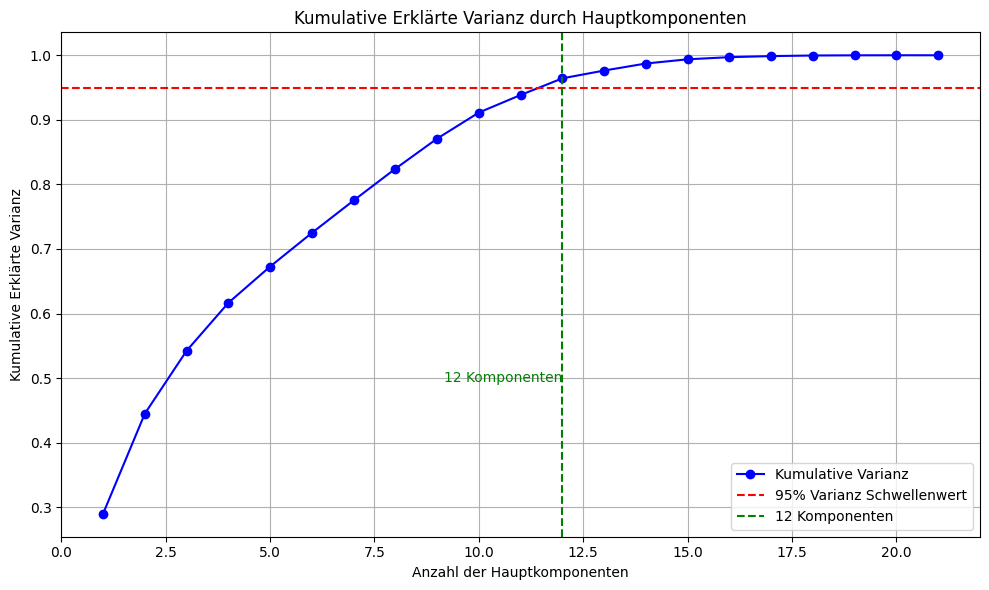

np.int64(12)

In [20]:
plot_cumulative_pca_variance(df_scaled=df_scaled)

In [21]:
def plot_pca_component_heatmap(
    component_matrix: pd.DataFrame,
    title: str = "PCA Component Loadings",
    figsize: tuple = (12, 8),
    cmap: str = "coolwarm",
    save_path: str = None
):
    """
    Plots a professional heatmap of absolute PCA component loadings.
    Args:
        component_matrix (pd.DataFrame): PCA components matrix with features as index
                                         and principal components as columns.
        title (str): Title of the heatmap.
        figsize (tuple): Figure size (width, height).
        cmap (str): Color map for the heatmap.
        save_path (str, optional): Path to save the figure. If None, figure is not saved.
    Returns:
        matplotlib.figure.Figure: The heatmap figure.
    """

    # Schritt 1: Absolutwerte der Loadings berechnen
    # → zeigt die Stärke des Zusammenhangs unabhängig vom Vorzeichen
    abs_matrix = component_matrix.abs()

    # Schritt 2: Figure erstellen
    plt.figure(figsize=figsize)

    # Schritt 3: Heatmap zeichnen
    # annot=True → Zahlenwerte direkt in den Zellen anzeigen
    # fmt=".2f" → zwei Nachkommastellen
    # cmap → Farbschema, standardmäßig "coolwarm"
    sns.heatmap(
        abs_matrix,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        linewidths=0.5,        # dünne Linien zwischen Zellen
        linecolor="gray",      # Farbe der Zelllinien
        cbar_kws={"label": "Absolute Loading"},  # Farblegende benennen
        square=False
    )

    # Schritt 4: Titel und Achsenbeschriftungen
    plt.title(title, fontsize=16, fontweight="bold")
    plt.ylabel("Features", fontsize=12)
    plt.xlabel("Principal Components", fontsize=12)

    # Schritt 5: Drehung der Labels für bessere Lesbarkeit
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.tight_layout()

    # Schritt 6: Heatmap speichern
    save_path = os.path.join(pca_fig_path, "absolute_pca_heatmap.png")
    plt.savefig(save_path, dpi=300)
    print(f":weißes_häkchen: Heatmap saved to: {save_path}")

    # Rückgabe: Figure-Objekt der Heatmap
    return plt.gcf()


:weißes_häkchen: Heatmap saved to: /Users/claudiatagbo/Masterschool/traveltide/reports/viz/pca/absolute_pca_heatmap.png


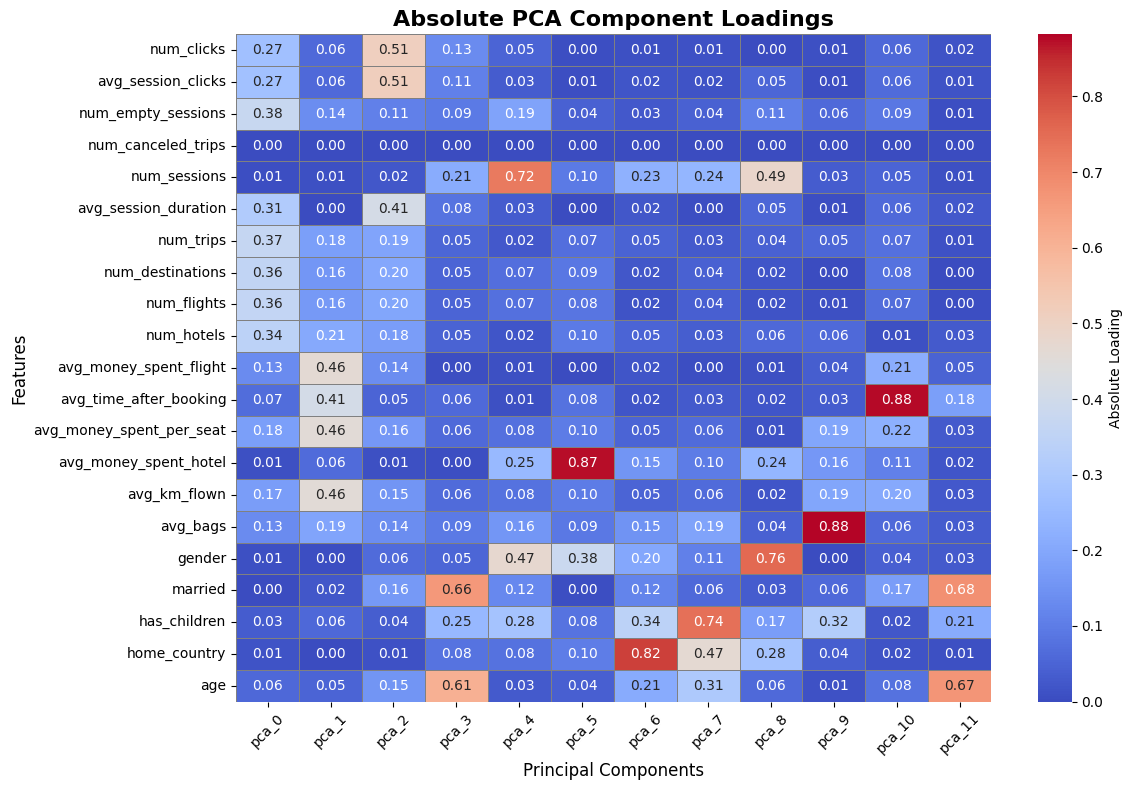

In [22]:
# Erstellen der Heatmap für die PCA-Komponenten-Matrix
heatmap_fig = plot_pca_component_heatmap(
    component_matrix=component_matrix,          # Übergeben der Komponentenmatrix aus der PCA
    title="Absolute PCA Component Loadings",     # Titel der Heatmap
    save_path="outputs/pca_component_heatmap.png"  # Speicherpfad für die Abbildung
)

# Heatmap anzeigen
plt.show()


In [23]:
df_pca.sample(5)

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11
user_id,,,,,,,,,,,,
512010,0.177538,-0.586927,-0.912210,1.816100,-0.765263,-0.105125,0.312318,0.363341,-0.827474,-0.489347,0.065293,-0.442807
582326,-2.036767,-1.363329,-0.998316,0.654741,-0.189266,-0.152808,0.062046,-0.438248,-0.683229,1.480285,0.496079,0.721838
444885,1.231895,1.575897,0.175782,0.593263,-0.315715,-0.128282,0.219867,-0.175617,-0.809276,2.829017,-0.571143,1.348180
508940,-2.563735,-0.782433,1.025503,-0.638712,0.723373,-1.179967,1.085846,-0.546377,2.884776,-0.776544,-0.072728,-0.056916
586384,-3.440240,-1.959247,0.458748,-1.573241,-0.312147,0.866818,-1.802941,0.866570,0.146305,0.142992,0.205284,0.100856


In [24]:
save_path = os.path.join(pca_data_path, "user_pca.csv")
df_pca.to_csv(save_path, index=True)